#Importing important modules and Dataset

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from sklearn.metrics import adjusted_rand_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#Basic EDA and plots to visualize different features


In [188]:
dataset=load_iris()
df=pd.DataFrame(dataset.data,columns=dataset.feature_names)
df['species']=dataset.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [189]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


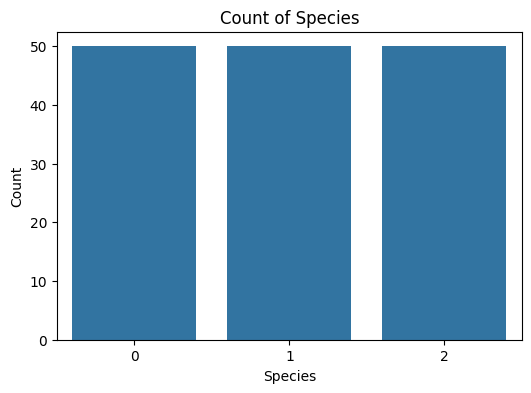

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='species', data=df)
plt.title('Count of Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.show()

In [192]:
import plotly.express as plx
fig=plx.scatter(df,x='sepal length (cm)',y='sepal width (cm)',color='species')
fig.show()

In [193]:
fig=plx.scatter(df,x='petal length (cm)',y='petal width (cm)',color='species')
fig.show()

In [194]:
fig=plx.scatter_matrix(df,color='species')
fig.show()


#After seeing various plots I decided to go with the features of Petal Length and Petal width

In [195]:
X=df[['petal length (cm)','petal width (cm)']]
y=df['species']

#Scaling the feature also making stratified train test split of 80/20


In [196]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

<Axes: xlabel='species', ylabel='count'>

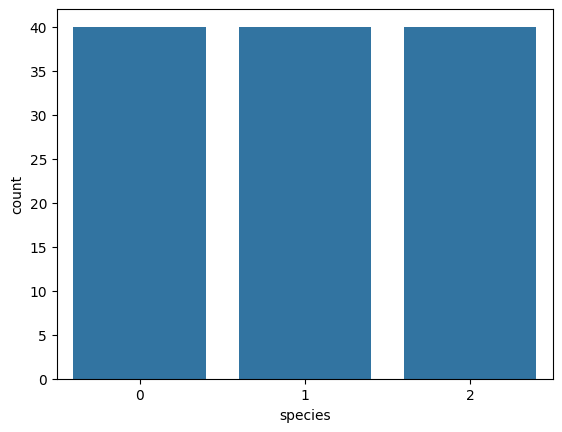

In [197]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
sns.countplot(x=y_train)

#Model trainning Phase

#1. K Means Clustering
#Using the elbow method the appropriate amount of cluster is found out to be "3"

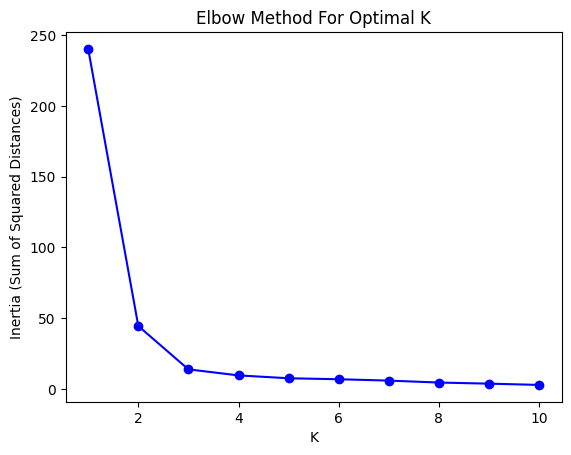

In [198]:
inertia = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_train)
    inertia.append(km.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('K')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal K')
plt.show()


#Trainning the model with K=3

In [199]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=3, random_state=69)
kmeans_model.fit(X_train)


KMeans(n_clusters=3, random_state=69)

#Labeling each clustering using majority vote that is what is the actual label for each cluster, the majority amount of point that belong to a certain class will be the clusters actual label

In [200]:
predicted_clusters_train = kmeans_model.predict(X_train)

temp_df = pd.DataFrame({'predicted_cluster': predicted_clusters_train, 'true_species': y_train})

cluster_to_species_mapping = temp_df.groupby('predicted_cluster')['true_species'].apply(lambda x: mode(x)[0]).to_dict()


print("Mapping of Predicted Clusters to True Species (Training Set):")
print(cluster_to_species_mapping)

mapped_labels_train = np.array([cluster_to_species_mapping[cluster] for cluster in predicted_clusters_train])

print("\nClassification Report (Training Set):")
print(classification_report(y_train, mapped_labels_train))

Mapping of Predicted Clusters to True Species (Training Set):
{0: 2, 1: 0, 2: 1}

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.97      0.95        40
           2       0.97      0.93      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



#Using the cluster to label the test datas and finding evaluation reports


Classification Report (Test Set):


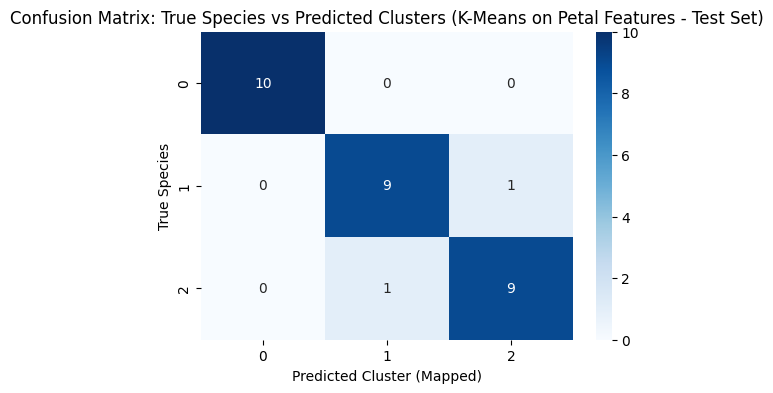

In [201]:
predicted_clusters_test = kmeans_model.predict(X_test)

y_pred_optimal_mapped = np.array([cluster_to_species_mapping[cluster] for cluster in predicted_clusters_test])

print("\nClassification Report (Test Set):")
k_means_cluster_reports=classification_report(y_test, y_pred_optimal_mapped)

cm_test_of_k_means_cluster = confusion_matrix(y_test, y_pred_optimal_mapped)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_of_k_means_cluster, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Cluster (Mapped)')
plt.ylabel('True Species')
plt.title('Confusion Matrix: True Species vs Predicted Clusters (K-Means on Petal Features - Test Set)')
plt.show()

#2. Heirarchical clustering


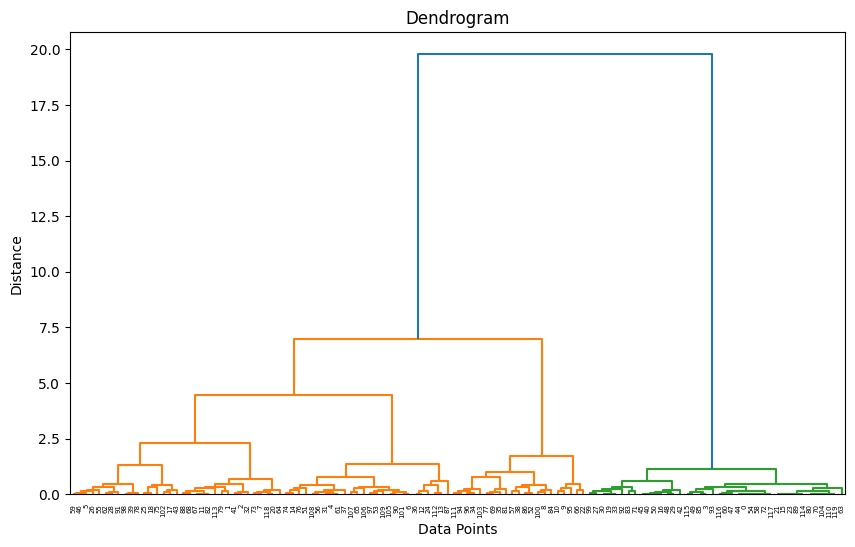

In [202]:
linked=linkage(X_train,method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


#Considering the dendogram the optimum amount of t would be '2' that would give us 5 clusters

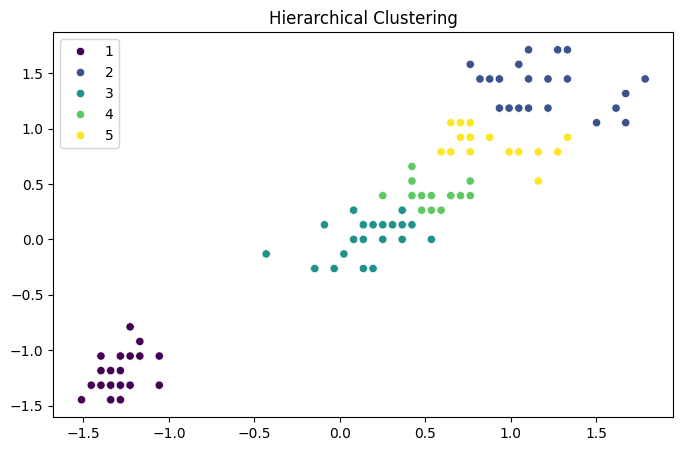

In [203]:
hc_labels=fcluster(linked,t=2,criterion='distance')
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=hc_labels, palette='viridis')
plt.title('Hierarchical Clustering')
plt.show()

#Now again giving labels to each cluster based on majority vote of each clusters actual labels

In [204]:
temp_df_hc = pd.DataFrame({'predicted_cluster': hc_labels, 'true_species': y_train})

hc_cluster_to_species_mapping = temp_df_hc.groupby('predicted_cluster')['true_species'].apply(lambda x: mode(x)[0]).to_dict()

print("Mapping of Hierarchical Clusters to True Species (Training Set):")
print(hc_cluster_to_species_mapping)

mapped_hc_labels_train = np.array([hc_cluster_to_species_mapping[cluster] for cluster in hc_labels])

print("\nClassification Report (Hierarchical Clustering - Training Set):")
print(classification_report(y_train, mapped_hc_labels_train))


Mapping of Hierarchical Clusters to True Species (Training Set):
{1: 0, 2: 2, 3: 1, 4: 1, 5: 2}

Classification Report (Hierarchical Clustering - Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.97      0.95        40
           2       0.97      0.93      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



#Now, to predict a new datapoint, first finding the average point of each clusters the nearest cluster will be new points label

In [205]:
X_train_df = pd.DataFrame(X_train)
X_train_df['hc_labels'] = hc_labels
hc_cluster_centroids = X_train_df.groupby('hc_labels').mean()
display(hc_cluster_centroids)

,0,1
hc_labels,,
1,-1.296178,-1.243047
2,1.206632,1.379881
3,0.155035,0.021129
4,0.531856,0.404001
5,0.869746,0.860358


#Predicting test values and assigning it to the nearest cluster


In [206]:
from scipy.spatial.distance import cdist

distances = cdist(X_test, hc_cluster_centroids, metric='euclidean')
hc_predicted_clusters_test = np.argmin(distances, axis=1) + 1
display(hc_predicted_clusters_test)

array([1, 5, 3, 3, 1, 4, 1, 1, 5, 4, 5, 2, 2, 4, 1, 1, 1, 3, 4, 5, 1, 2,
       4, 4, 2, 5, 4, 1, 5, 1])

In [207]:
mapped_hc_labels_test = np.array([hc_cluster_to_species_mapping[cluster] for cluster in hc_predicted_clusters_test])


Classification Report (Hierarchical Clustering - Test Set):


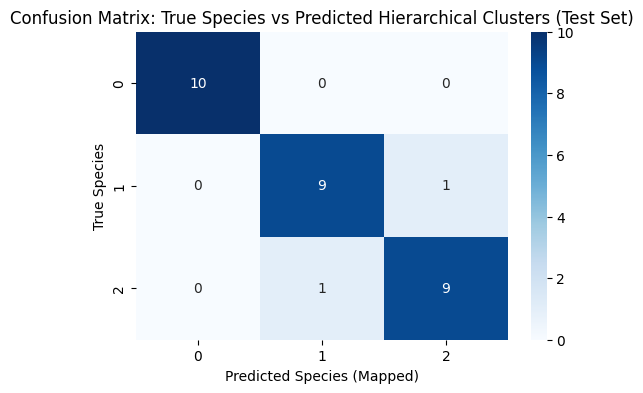

In [208]:
print("\nClassification Report (Hierarchical Clustering - Test Set):")
heirarchical_clustering_report=classification_report(y_test, mapped_hc_labels_test)

cm_test_of_heirarchical_clustering = confusion_matrix(y_test, mapped_hc_labels_test)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_of_heirarchical_clustering, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Species (Mapped)')
plt.ylabel('True Species')
plt.title('Confusion Matrix: True Species vs Predicted Hierarchical Clusters (Test Set)')
plt.show()

#3. DBSCAN


#For this I tried to use only petal length and width but couldn't get desired results, then decided to include all the feature

#Tuning values of min_sample and epsilon, I chose it to be 7 and 0.3(on scaled data) that gives the optimum results I was hoping for, also used *PCA* for better results and visualization

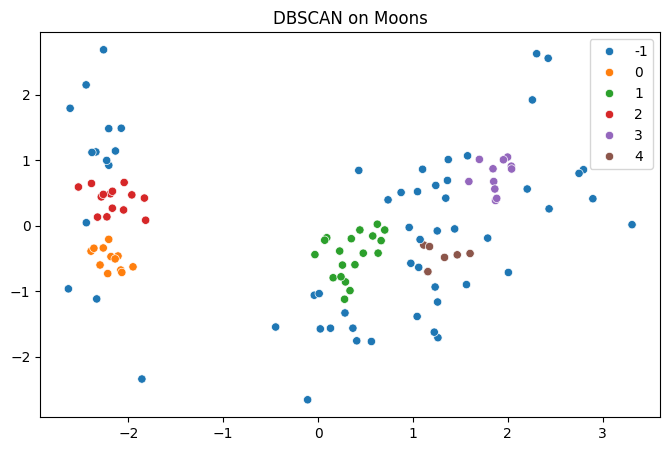

In [209]:
db=DBSCAN(min_samples=7,eps=0.3)
dataset=load_iris()
df=pd.DataFrame(dataset.data,columns=dataset.feature_names)
X=df
y=dataset.target
scaler=StandardScaler()
X=scaler.fit_transform(X)
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X_pca,y,test_size=0.2,random_state=42,stratify=y)
db_labels=db.fit_predict(X_train)
plt.figure(figsize=(8, 5))
plt.title('DBSCAN on Moons')
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=db_labels, palette='tab10')
plt.show()

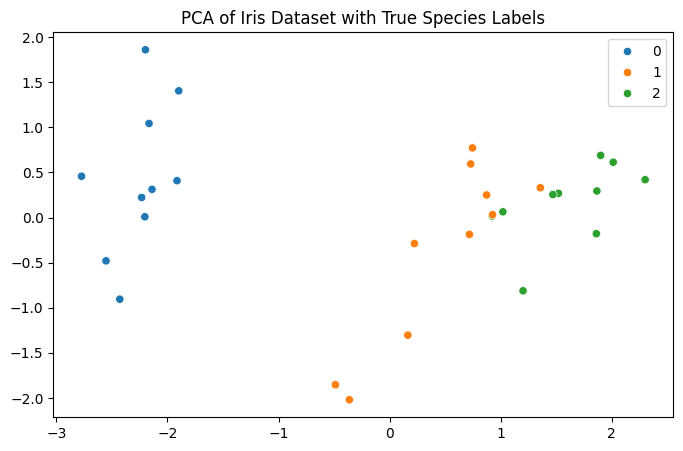

In [210]:
plt.figure(figsize=(8, 5))
plt.title('PCA of Iris Dataset with True Species Labels')
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, palette='tab10')
plt.show()

#Again, giving labels to the clusters

In [211]:
temp_df_dbscan = pd.DataFrame({'predicted_cluster': db_labels, 'true_species': y_train})

dbscan_cluster_to_species_mapping = temp_df_dbscan[temp_df_dbscan['predicted_cluster'] != -1].groupby('predicted_cluster')['true_species'].apply(lambda x: mode(x)[0]).to_dict()

print("Mapping of DBSCAN Clusters to True Species (Training Set):")
print(dbscan_cluster_to_species_mapping)

Mapping of DBSCAN Clusters to True Species (Training Set):
{0: 0, 1: 1, 2: 0, 3: 2, 4: 2}


#Finding the core points to predict test data points

In [212]:
training_data_core = [X_train[i] for i in db.core_sample_indices_]
training_clusters = db_labels[db.core_sample_indices_]
distances = cdist(X_test, training_data_core, metric='euclidean')

nearest_core_point_indices = np.argmin(distances, axis=1)

dbscan_predicted_clusters_test = training_clusters[nearest_core_point_indices]
y_predict=[dbscan_cluster_to_species_mapping[i] for i in dbscan_predicted_clusters_test]


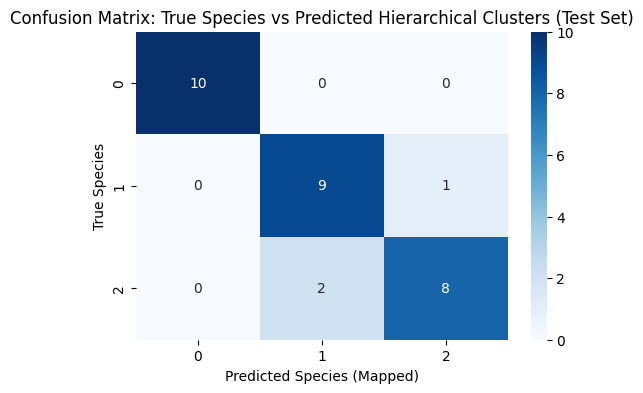

In [213]:
report_of_DBSCAN=classification_report(y_test, y_predict)

cm_test_dbscan = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_dbscan, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Species (Mapped)')
plt.ylabel('True Species')
plt.title('Confusion Matrix: True Species vs Predicted Hierarchical Clusters (Test Set)')
plt.show()

#Comparing all the models classification reports and confusion matrices

#1. K means clustering


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Adjusted Rand Score (Test Set):
0.8066666666666666


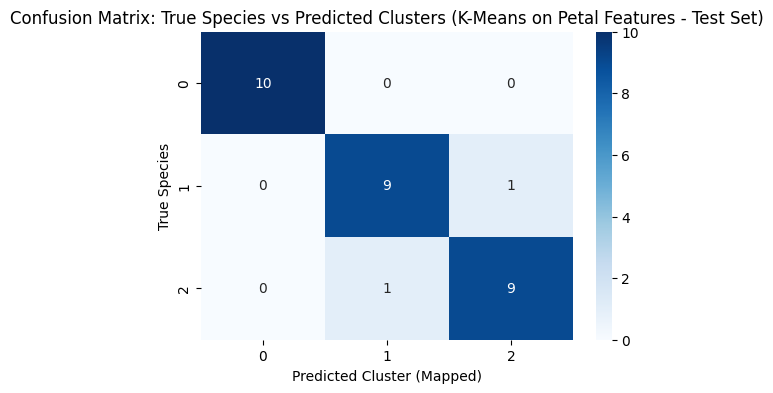

In [214]:
print("\nClassification Report (Test Set):")
print(k_means_cluster_reports)
print("\nAdjusted Rand Score (Test Set):")
print(adjusted_rand_score(y_test, y_pred_optimal_mapped))
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_of_k_means_cluster, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Cluster (Mapped)')
plt.ylabel('True Species')
plt.title('Confusion Matrix: True Species vs Predicted Clusters (K-Means on Petal Features - Test Set)')
plt.show()

#2. Heirarcical Clustering


Classification Report (Hierarchical Clustering - Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Adjusted Rand Score (Test Set):
0.8066666666666666


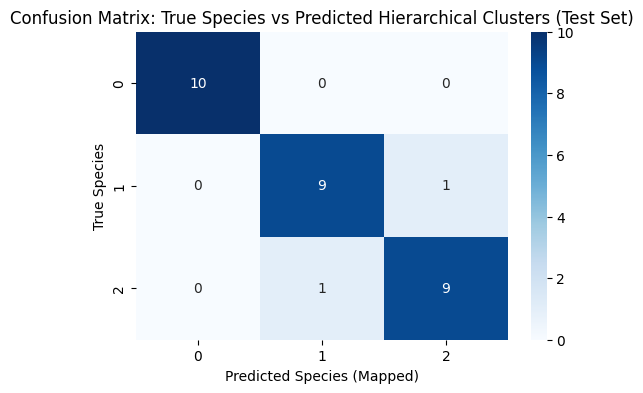

In [215]:
print("\nClassification Report (Hierarchical Clustering - Test Set):")
print(heirarchical_clustering_report)
print("\nAdjusted Rand Score (Test Set):")
print(adjusted_rand_score(y_test, mapped_hc_labels_test))
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_of_heirarchical_clustering, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Species (Mapped)')
plt.ylabel('True Species')
plt.title('Confusion Matrix: True Species vs Predicted Hierarchical Clusters (Test Set)')
plt.show()

#3. DBSCAN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30


Adjusted Rand Score (Test Set):
0.7266678987248198


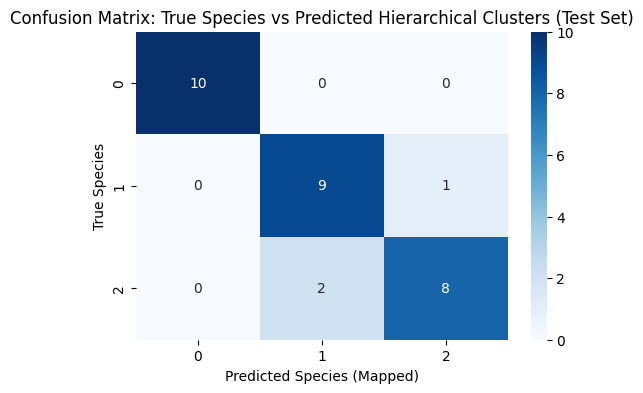

In [216]:
print(report_of_DBSCAN)
print("\nAdjusted Rand Score (Test Set):")
print(adjusted_rand_score(y_test, y_predict))
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_dbscan, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Species (Mapped)')
plt.ylabel('True Species')
plt.title('Confusion Matrix: True Species vs Predicted Hierarchical Clusters (Test Set)')
plt.show()